## Download and setup of the dataset
Download the dataset from KaggleHub and define base path.

In [ ]:
import kagglehub
import os

# Download the dataset from KaggleHub
path = kagglehub.dataset_download("swapnilpanda/heart-sound-database")

# Print the local path where the dataset has been stored
print("Path to dataset files:", path)

# Define the base path pointing specifically to the "heart_sound" folder inside the dataset
base_path = os.path.join(path, "heart_sound")

Using Colab cache for faster access to the 'heart-sound-database' dataset.
Path to dataset files: /kaggle/input/heart-sound-database


## Audio preprocessing functions
Define functions for load, filtering, normalization and segmentation of the signals.

In [ ]:
import librosa
import jax
import jax.numpy as jnp
from collections import defaultdict
import random
from scipy.signal import butter, filtfilt

# Load an audio file and resample it to the given sampling rate (default: 2000 Hz)
def load_audio(file_path, sr=2000):
    audio, sr_ret = librosa.load(file_path, sr=sr)
    return audio

# Downsample a signal from original sampling rate to target sampling rate
def downsample_signal(signal, original_sr, target_sr):
    signal_np = jax.device_get(signal)  # Convert JAX array (jnp) to NumPy array
    return librosa.resample(signal_np, orig_sr=original_sr, target_sr=target_sr)

# Normalize audio to have zero mean and unit variance
def normalize_audio(x):
    return (x - jnp.mean(x)) / (jnp.std(x) + 1e-8)

# Split signal into fixed-length segments with optional overlap (stride)
def segment_signal(signal, segment_length, stride=None):
    if stride is None:
        stride = segment_length  # Default: no overlap
    segments = []
    for start in range(0, len(signal) - segment_length + 1, stride):
        segment = signal[start:start + segment_length]
        segments.append(segment)
    return segments

# Randomly sample a Signal-to-Noise Ratio (SNR) value
def sample_snr(key):
    snr_values = jnp.array([30, 20, 10, 5])
    idx = jax.random.randint(key, shape=(), minval=0, maxval=len(snr_values))
    return snr_values[idx]

# Add noise to a signal at a given SNR level (default: white noise)
def add_noise(signal, key, noise_type='white', snr_db=20):
    rms_signal = jnp.sqrt(jnp.mean(signal**2))

    if noise_type == 'white':
        noise = jax.random.normal(key, shape=signal.shape)
    else:
        raise ValueError(f"Unsupported noise type: {noise_type}")

    rms_noise = jnp.sqrt(jnp.mean(noise**2))
    desired_rms_noise = rms_signal / (10**(snr_db / 20))
    noise_scaled = noise * (desired_rms_noise / (rms_noise + 1e-8))

    return signal + noise_scaled

# Apply a Butterworth bandpass filter to remove frequencies outside [lowcut, highcut]
def butter_bandpass_filter(signal, lowcut=25.0, highcut=400.0, fs=1000.0, order=4):
    nyq = 0.5 * fs  # Nyquist frequency
    low = lowcut / nyq
    high = highcut / nyq

    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)

    return filtered_signal

# Load dataset grouped by input_id and apply preprocessing
def load_dataset_grouped(base_path, add_noise_flag=False):
    key = jax.random.PRNGKey(0)
    dataset = {'train': defaultdict(list), 'val': defaultdict(list)}
    labels = {'train': {}, 'val': {}}

    for split in ['train', 'val']:
        input_id = 0
        for label in ['healthy', 'unhealthy']:
            folder = os.path.join(base_path, split, label)
            if not os.path.exists(folder):
                print(f"Folder not found: {folder}")
                continue
            for fname in os.listdir(folder):
                if fname.endswith('.wav'):
                    file_path = os.path.join(folder, fname)
                    audio = load_audio(file_path, sr=2000)

                    # Optionally add random noise to audio
                    if add_noise_flag:
                        key, snr_key = jax.random.split(key)
                        snr_random = sample_snr(snr_key)

                        key, noise_key = jax.random.split(key)
                        audio = add_noise(audio, noise_key, noise_type='white', snr_db=snr_random)

                    # Apply bandpass filter, downsample to 1000 Hz, normalize
                    audio_filtered = butter_bandpass_filter(audio, lowcut=25.0, highcut=400.0, fs=2000.0)
                    audio_downsample = downsample_signal(audio_filtered, 2000, 1000)
                    audio_normalize = normalize_audio(audio_downsample)

                    # Split into overlapping segments (length=2500, stride=1250)
                    segment_length = 2500
                    segments = segment_signal(audio_normalize, segment_length=segment_length, stride=segment_length//2)

                    # Store segments and label for each input_id
                    for segment in segments:
                        dataset[split][input_id].append(segment)

                    labels[split][input_id] = 0 if label == 'healthy' else 1
                    input_id += 1

    return dataset, labels

# Path to the heart_sound dataset folder
base_path = os.path.join(path, "heart_sound")

# Access:
# grouped_dataset['train'][input_id] --> list of audio segments for that sample
# labels['train'][input_id]          --> label (0=healthy, 1=unhealthy)

## Load the dataset
Load the heart sound dataset with preprocessing (filtering, downsampling, normalization, segmentation).



In [ ]:
# Load and preprocess the dataset (train/val split, segmentation, normalization, filtering)
grouped_dataset, labels = load_dataset_grouped(base_path, add_noise_flag=False)

# Quick sanity check
print(f"Train samples: {len(grouped_dataset['train'])}")
print(f"Validation samples: {len(grouped_dataset['val'])}")

first_id = list(grouped_dataset['train'].keys())[0]
print(f"Example train sample (n_segments): {len(grouped_dataset['train'][first_id])}")
print(f"Label: {labels['train'][first_id]}")

Train samples: 3240
Validation samples: 301
Example train sample (n_segments): 5
Label: 0


## Train/Validation split
Extract training and validation subsets from the grouped dataset.


In [ ]:
# Split grouped dataset and labels into training and validation sets
grouped_train = grouped_dataset['train']
labels_train = labels['train']

grouped_val = grouped_dataset['val']
labels_val = labels['val']

# Quick consistency check
print(f"Train IDs: {len(grouped_train)}, Val IDs: {len(grouped_val)}")

Train IDs: 3240, Val IDs: 301


## Custom data generator
Define a custom Keras `Sequence` to handle grouped heart sound signals.
This ensures batching, shuffling, and consistent handling of multiple segments per patient.


In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np

# Custom Keras Sequence class to handle grouped heart sound dataset
class HeartSoundGroupedDataset(Sequence):
    def __init__(self, grouped_data, labels, min_segments_per_batch=1, shuffle=True, **kwargs):
        super().__init__(**kwargs)
        self.grouped_data = grouped_data      # Dictionary: input_id -> list of audio segments
        self.labels = labels                  # Dictionary: input_id -> label (0 or 1)
        self.input_ids = list(grouped_data.keys())  # List of available sample IDs
        self.min_segments_per_batch = min_segments_per_batch  # Minimum number of segments per batch
        self.shuffle = shuffle
        self.batches = self.create_batches()  # Precompute batches

    # Create batches ensuring at least 'min_segments_per_batch' segments are in each batch
    def create_batches(self):
        if self.shuffle:
            np.random.shuffle(self.input_ids)  # Shuffle IDs at the start

        batches = []
        current_batch = []
        current_count = 0

        for input_id in self.input_ids:
            segments = self.grouped_data[input_id]
            n_segments = len(segments)

            current_batch.append(input_id)
            current_count += n_segments

            # When the minimum segment count is reached, finalize the batch
            if current_count >= self.min_segments_per_batch:
                batches.append(current_batch)
                current_batch = []
                current_count = 0

        # Add last batch even if it has fewer segments
        if current_batch:
            batches.append(current_batch)

        return batches

    # Return number of batches per epoch
    def __len__(self):
        return len(self.batches)

    # Return data for one batch (called by Keras during training)
    def __getitem__(self, index):
        batch_ids = self.batches[index]
        batch_x = []
        batch_y = []

        for input_id in batch_ids:
            segments = self.grouped_data[input_id]
            # Stack segments and add channel dimension -> (n_segments, segment_length, 1)
            segments = np.expand_dims(np.stack(segments), -1)
            label = self.labels[input_id]

            batch_x.append(segments)

            # Create metadata [input_id, label], repeated for each segment
            meta = np.array([input_id, label])
            meta_repeated = np.repeat(meta[np.newaxis, :], len(segments), axis=0)
            batch_y.append(meta_repeated)

        # Concatenate all segments across input_ids
        batch_x = np.concatenate(batch_x, axis=0)  # shape: (>=min_segments, segment_length, 1)
        batch_y = np.concatenate(batch_y, axis=0)  # shape: (>=min_segments, 2)

        return batch_x, batch_y

    # Called automatically at the end of each epoch to reshuffle and rebuild batches
    def on_epoch_end(self):
        self.batches = self.create_batches()


## Custom loss & metrics
Define a grouped Binary Crossentropy loss and grouped Binary Accuracy metric.  
Each patient (input_id) has multiple audio segments: predictions are averaged before computing loss/metrics.


In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf

# Custom grouped Binary Crossentropy (BCE) loss function
def custom_grouped_bce(y_true, y_pred):
    # y_true: (batch_size, 2): [input_id, label]
    # y_pred: (batch_size, 1)

    # Extract input IDs and labels
    input_ids = tf.cast(y_true[:, 0], tf.int32)  # input_id as integer
    labels = y_true[:, 1]  # label (0 or 1)

    # Find unique input IDs and their corresponding indices
    unique_ids, idx = tf.unique(input_ids)

    # Compute mean predictions per input_id
    pred_means = tf.math.unsorted_segment_mean(
        y_pred[:, 0], idx, tf.shape(unique_ids)[0]
    )
    # Compute labels per input_id (max ensures consistent group label)
    labels = tf.cast(
        tf.math.unsorted_segment_max(labels, idx, tf.shape(unique_ids)[0]), tf.float32
    )

    # Compute BCE between averaged predictions and labels
    loss = tf.keras.losses.binary_crossentropy(labels, pred_means)
    return tf.reduce_mean(loss)


# Custom grouped Binary Accuracy metric
def grouped_binary_accuracy(y_true, y_pred):
    input_ids = tf.cast(y_true[:, 0], tf.int32)
    labels = y_true[:, 1]

    # Find unique input IDs and their indices
    unique_ids, idx = tf.unique(input_ids)

    # Compute mean predictions per input_id
    pred_means = tf.math.unsorted_segment_mean(
        y_pred[:, 0], idx, tf.shape(unique_ids)[0]
    )
    # Group labels (max is used in case of duplicates)
    labels = tf.cast(
        tf.math.unsorted_segment_max(labels, idx, tf.shape(unique_ids)[0]), tf.float32
    )

    # Convert averaged predictions to binary classification (threshold = 0.5)
    pred_binary = tf.cast(pred_means >= 0.5, tf.float32)

    # Compare predicted vs true labels
    correct = tf.cast(tf.equal(pred_binary, labels), tf.float32)
    return tf.reduce_mean(correct)

## Data Generators
Wrap the grouped dataset into Keras `Sequence` generators for training and validation.
This ensures efficient batch loading and on-the-fly reshuffling between epochs.


In [ ]:
train_gen = HeartSoundGroupedDataset(grouped_train, labels_train)
val_gen = HeartSoundGroupedDataset(grouped_val, labels_val, shuffle=False)

## Model definition
Define a 1D Convolutional Neural Network (CNN) for heart sound classification.
The model progressively extracts temporal features, downsamples with pooling,
and ends with dense layers for binary classification.


In [ ]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Parametri di esempio
input_length = grouped_train[0][0].shape[0]  # lunghezza della sequenza in input
num_channels = 1     # canali in input (es. 1 per segnali monodimensionali)
num_classes = 1      # output binario

model = Sequential([
    Conv1D(filters=16, kernel_size=5, activation='relu', input_shape=(input_length, num_channels)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='sigmoid')
])

model.compile(optimizer='SGD', loss=custom_grouped_bce, metrics=[grouped_binary_accuracy])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2496, 16)       │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1248, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1244, 32)       │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 622, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 19904)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,273,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,276,673 (4.87 MB)

 Trainable params: 1,276,673 (4.87 MB)

 Non-trainable params: 0 (0.00 B)

## Training the CNN
Train the model on the grouped heart sound dataset for 10 epochs.

In [ ]:
history = model.fit(train_gen,
          validation_data=val_gen,
          epochs=10)


Epoch 1/10
3240/3240 ━━━━━━━━━━━━━━━━━━━━ 189s 57ms/step - grouped_binary_accuracy: 0.8006 - loss: 0.5461 - val_grouped_binary_accuracy: 0.4983 - val_loss: 0.7814
Epoch 2/10
3240/3240 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - grouped_binary_accuracy: 0.7954 - loss: 0.4613 - val_grouped_binary_accuracy: 0.5216 - val_loss: 0.6933
Epoch 3/10
3240/3240 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - grouped_binary_accuracy: 0.8087 - loss: 0.4219 - val_grouped_binary_accuracy: 0.5548 - val_loss: 0.7567
Epoch 4/10
3240/3240 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - grouped_binary_accuracy: 0.8294 - loss: 0.3720 - val_grouped_binary_accuracy: 0.8073 - val_loss: 0.5071
Epoch 5/10
3240/3240 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - grouped_binary_accuracy: 0.8697 - loss: 0.3125 - val_grouped_binary_accuracy: 0.6811 - val_loss: 0.6485
Epoch 6/10
3240/3240 ━━━━━━━━━━━━━━━━━━━━ 41s 7ms/step - grouped_binary_accuracy: 0.9038 - loss: 0.2539 - val_grouped_binary_accuracy: 0.8837 - val_loss: 0.4012
Epoch 7/10
3240/3240 ━━━━━━━━━━━

## Model Evaluation
Evaluate the CNN on the validation set by aggregating predictions for each audio sample.
Metrics include accuracy, AUC, precision, recall, and F1-score. A confusion matrix visualizes performance per class.


Aggregated evaluation per audio input:
Accuracy       : 0.9668
AUC            : 0.9985
Precision      : 1.0000
Recall         : 0.9338
F1-score       : 0.9658

 Classification Report:
              precision    recall  f1-score   support

     Healthy       0.94      1.00      0.97       150
   Unhealthy       1.00      0.93      0.97       151

    accuracy                           0.97       301
   macro avg       0.97      0.97      0.97       301
weighted avg       0.97      0.97      0.97       301



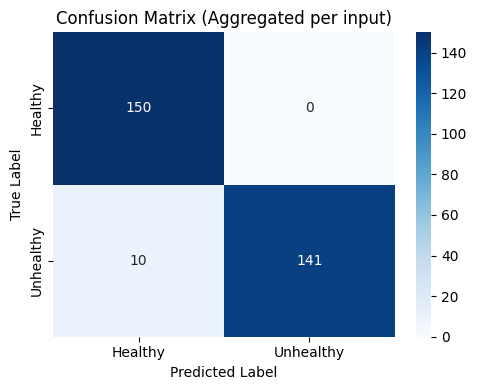

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, roc_auc_score, confusion_matrix,
    precision_score, recall_score, f1_score, classification_report
)

# === Prediction ===
grouped_preds = []
grouped_labels = []

for input_id, segments in grouped_val.items():
    # Prepare the segments
    X = np.expand_dims(np.stack(segments), axis=-1)  # (n_segments, segment_length, 1)

    # Predict probabilities for each segment
    y_segment_pred = model.predict(X, verbose=0).reshape(-1)  # (n_segments,)

    # Aggregate: mean probability per input_id
    mean_pred = y_segment_pred.mean()
    grouped_preds.append(mean_pred)

    # Retrieve the true label
    grouped_labels.append(labels_val[input_id])

# === Post-processing ===
grouped_preds = np.array(grouped_preds)
grouped_labels = np.array(grouped_labels)

# Binarize predictions
grouped_pred_labels = (grouped_preds > 0.5).astype(int)

# === Metrics ===
acc = accuracy_score(grouped_labels, grouped_pred_labels)
auc = roc_auc_score(grouped_labels, grouped_preds)
prec = precision_score(grouped_labels, grouped_pred_labels)
rec = recall_score(grouped_labels, grouped_pred_labels)
f1 = f1_score(grouped_labels, grouped_pred_labels)

# === Output ===
print("Aggregated evaluation per audio input:")
print(f"Accuracy       : {acc:.4f}")
print(f"AUC            : {auc:.4f}")
print(f"Precision      : {prec:.4f}")
print(f"Recall         : {rec:.4f}")
print(f"F1-score       : {f1:.4f}")
print("\n Classification Report:")
print(classification_report(grouped_labels, grouped_pred_labels, target_names=["Healthy", "Unhealthy"]))

# === Confusion Matrix ===
cm = confusion_matrix(grouped_labels, grouped_pred_labels)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Unhealthy"], yticklabels=["Healthy", "Unhealthy"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Aggregated per input)")
plt.tight_layout()
plt.show()

